_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [255]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [256]:
import pandas as pd 

# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [257]:
y_train = df['shot_made_flag']
y_train.value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [258]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
print(len(y_pred))

13958


In [259]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5270812437311936

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [261]:
# train test split
train = df[df['game_date'] <= '2018-09-30']

test = df[df['game_date'] >= '2018-10-1']

train.shape, test.shape

((12249, 20), (1709, 20))

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [263]:
def wrangle(x):
    """wrangle trian, val, and test sets in the same way"""
    
    # make copy
    x = x.copy()
    
    # engineer new features
    
    # home team advantage
    x['home_advantage'] = x['htm'] == 'GSW'
        
    # seconds remaining in the period
    x['time_remaining_in_period'] = (x['minutes_remaining'] * 60) + x['seconds_remaining']
    
    # seconds remaining in the game
    x['total_time_remaining'] = ((4 - x['period']) * 12 * 60) + x['time_remaining_in_period']
    
    # previous shot succesful?
    index = x.index
    x['previous_shot'] = x['shot_made_flag'].shift(1) == 1
    
    return x

In [264]:
train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((12249, 24), (1709, 24))

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [265]:
# used StratifiedKFold built into RandomizedSearchCV

target = 'shot_made_flag'

x_train = train.drop(columns=target)
y_train = train[target]
x_test = test.drop(columns=target)
y_test = test[target]

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [266]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__min_samples_split': range(2, 10), 
    'randomforestclassifier__max_features': ['auto', 1, 0.5, .25],
    'randomforestclassifier__max_depth': range(5,25),
    'randomforestclassifier__n_jobs': [-1],
    'randomforestclassifier__n_estimators': [100]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    random_state=0,
    n_jobs=-1
)

search.fit(x_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

In [267]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'most_frequent', 'randomforestclassifier__n_jobs': -1, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__max_depth': 5}
Accuracy 0.6608702751244999


In [268]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=100,
                           random_state=0,
                           min_samples_split=3,
                           max_features=0.5,
                           max_depth=5,
                           n_jobs=-1
    )
)

# Fit on train, score on val
pipeline.fit(x_train, y_train)

# print scores
print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

Train Accuracy 0.6665033880316761
Validation Accuracy 0.6760204081632653


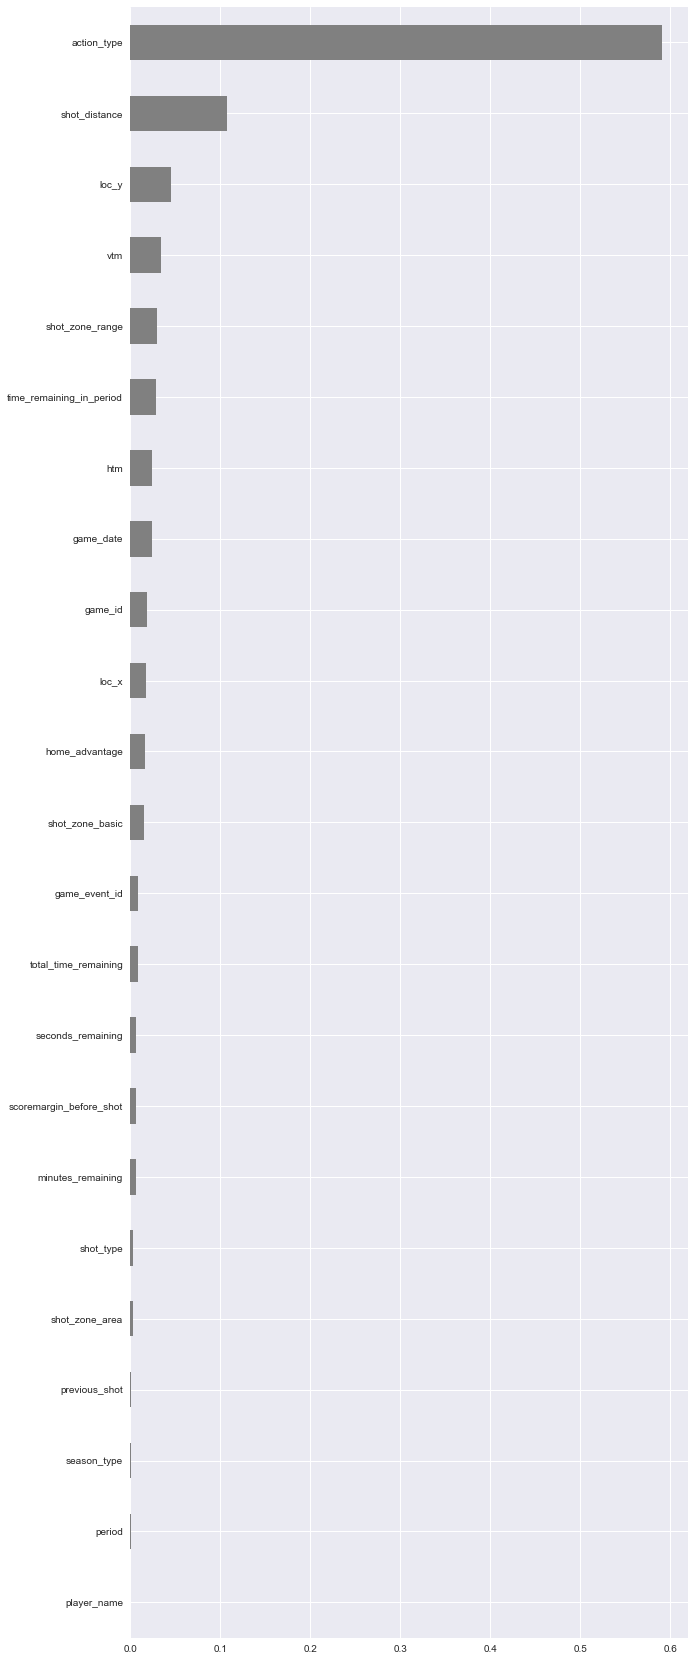

In [269]:
# feature importances

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(x_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

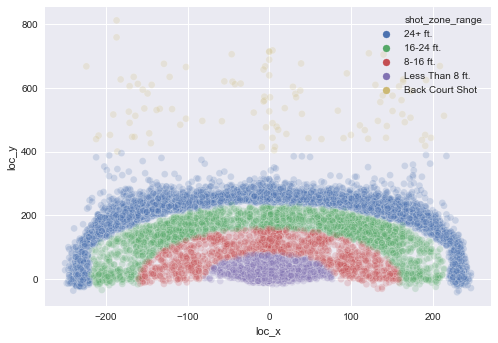

In [301]:
import seaborn as sns

sns.scatterplot(x=df['loc_x'], y=df['loc_y'], alpha=0.2, hue=df['shot_zone_range']);

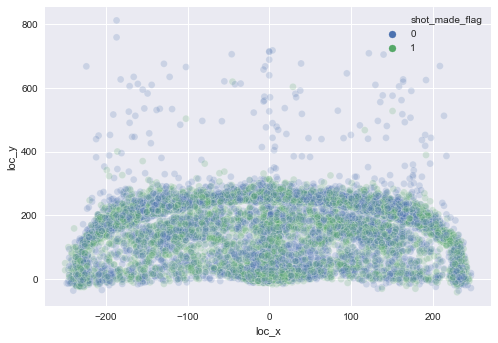

In [302]:
import seaborn as sns

sns.scatterplot(x=df['loc_x'], y=df['loc_y'], alpha=0.2, hue=df['shot_made_flag']);

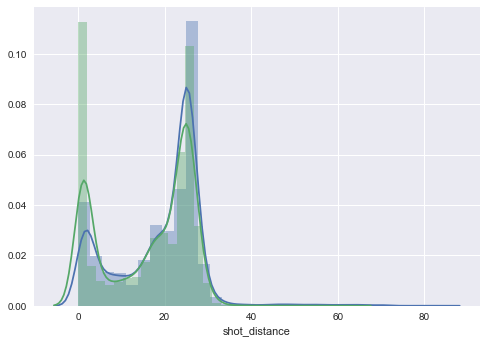

In [305]:
sns.distplot(df['shot_distance'][df['shot_made_flag'] == 0], bins=30)
sns.distplot(df['shot_distance'][df['shot_made_flag'] == 1], bins=30);

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [270]:
pipeline.score(x_val, y_val)

0.6760204081632653

## 7. Get your model's test accuracy

> (One time, at the end.)

In [271]:
pipeline.score(x_test, y_test)

0.6208308952603862

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [237]:
correct_predictions = 85 + 36
total_predictions = 85 + 58 + 8 + 36
correct_predictions / total_predictions

0.6470588235294118

### Calculate precision

In [240]:
# precision for negative
correct_predictions_negative = 85
total_predictions_negative = 85 + 8

correct_predictions_negative / total_predictions_negative

0.9139784946236559

In [241]:
# precision for positive
correct_predictions_positive = 36
total_predictions_positive = 58 + 36

correct_predictions_positive / total_predictions_positive

0.3829787234042553

### Calculate recall

In [243]:
# recall for negative
actual_negative = 85 + 58
correct_predictions_negative/actual_negative

0.5944055944055944

In [244]:
# recall for positive
actual_positive = 8 + 36
correct_predictions_positive/actual_positive

0.8181818181818182